In [1]:
import os
from pathlib import Path
import open3d as o3d
import laspy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import geomapi 
from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
import geomapi.tools as tl
import geomapi.tools.progresstools as pt

## IMPORT PCD

In [3]:
filePath=r"C:\Users\SamDeGeyter\OneDrive - KU Leuven\2024-05 CVPR scan-to-BIM challenge\data\full_resolution_labo-grond.laz"

In [4]:
laz = laspy.read(filePath)
point_cloud_o3d = gmu.las_to_pcd(laz)

In [5]:
node=PointCloudNode(resource=point_cloud_o3d)
# {key:value for key, value in node.__dict__.items() if not key.startswith('__') and not callable(key)} 

In [6]:
# o3d.visualization.draw_geometries([node.resource])

In [7]:
octree=pt.pcd_to_octree(point_cloud_o3d,10) #if octree is None else octree
mesh=gmu.octree_to_voxelmesh(octree) #if mesh is None else mesh

In [8]:
#create a colorArray from the mesh triangles (color of first vertex is taken)
colors=np.asarray(mesh.vertex_colors)
indices=np.asarray(mesh.triangles)[:,0]
triangle_colors=colors[indices]
#append black color at the end of the array for the invalid hits
triangle_colors=np.vstack((triangle_colors,np.array([0,0,0])))
print(triangle_colors.shape)

(42626521, 3)


In [9]:
o3d.visualization.draw_geometries([mesh])

In [10]:
bbox_center = mesh.get_center()
# print("Center of the mesh:", bbox_center)

# center_point = o3d.geometry.PointCloud()
# center_point.points = o3d.utility.Vector3dVector([bbox_center])
# center_point.paint_uniform_color([1,0,0])

# o3d.io.write_point_cloud("center.pcd", center_point)

In [59]:
# Define parameters
image_size = (800,400)  # Image resolution
ray_origin = np.array([bbox_center[0], bbox_center[1], bbox_center[2]]) #np.array(bbox_center)  # Center point

theta_step = 2* np.pi / image_size[0]
phi_step = np.pi / image_size[1]

theta_start = -np.pi
theta_stop = np.pi

phi_start = np.pi/2
phi_stop = -np.pi/2

In [64]:
# Define the range and step size for phi and theta
theta = np.arange(theta_start, theta_stop, theta_step) # Using -0.001 to ensure inclusive end
phi = np.arange(phi_start, phi_stop , -phi_step)  # Using -0.001 to ensure inclusive end

# Generate the grid of phi and theta values
theta_grid,phi_grid  = np.meshgrid(theta, phi)

# Calculate the corresponding values using the given formula
ori_x = np.cos(phi_grid) * np.sin(theta_grid)
ori_y = np.cos(phi_grid) * np.cos(theta_grid)
ori_z = np.sin(phi_grid)
pos_x = bbox_center[0] * np.ones_like(ori_x)
pos_y = bbox_center[1] * np.ones_like(ori_x)
pos_z = bbox_center[2] * np.ones_like(ori_x)

# Stack the calculated values along the third axis to create the grid
grid_values = np.stack((pos_x, pos_y, pos_z, ori_x, ori_y, ori_z), axis=2)

# Print the grid values
# print(grid_values)
# Reshape the resulting array
reshaped_grid = grid_values.reshape((-1, 6), order='C')  # Reshape to have 6 columns, using Fortran (column-major) order

# Convert the NumPy array to Open3D tensor
o3d_tensor = o3d.core.Tensor(reshaped_grid, dtype=o3d.core.Dtype.Float32)

# Print the shape of the resulting Open3D tensor
# print(o3d_tensor)

In [65]:
# # Create raycasting scene
scene = o3d.t.geometry.RaycastingScene()
reference=o3d.t.geometry.TriangleMesh.from_legacy(mesh)

# Add mesh to the scene
scene.add_triangles(reference)  

ans = scene.cast_rays(o3d_tensor)

In [66]:
#get triangle_ids that are hit per ray
triangle_ids=ans["primitive_ids"].numpy() # triangles
print(triangle_ids.shape)
# rows,columns=triangle_ids.shape        
triangle_ids=triangle_ids.flatten()
# replace invalid id's by last (which is the above added black color)
np.put(triangle_ids,np.where(triangle_ids==scene.INVALID_ID),triangle_colors.shape[0]-1) 

#select colors 
colors=triangle_colors[triangle_ids]
#reshape array back to normal
colorImage=np.reshape(colors,(image_size[1],image_size[0],3))

(320000,)


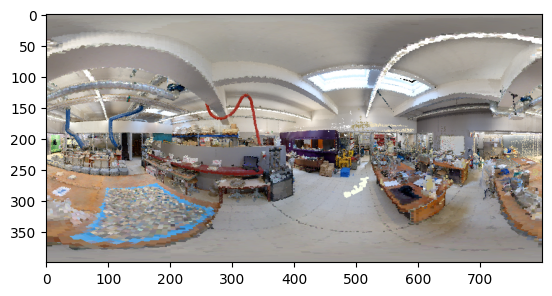

In [63]:
plt.imshow(colorImage)
plt.show()

In [57]:
# # Create a blank image
# image = np.zeros((image_size[1], image_size[0], 3), dtype=np.uint8)

# # Process intersection results
# print(ans["geometry_ids"].shape[0])
# for i in range(ans["geometry_ids"].shape[0]):
#     if ans["geometry_ids"][i] >= 0 and not ans["geometry_ids"][i] == 4294967295:  # Check if intersection is found
#         x, y = i % image_size[1], i // image_size[1]
#         # print(x,y)
#         triangle_id = int(ans["primitive_ids"][i].item())
#         triangle_vertices = np.asarray(mesh.triangles)[triangle_id]  # Convert to NumPy array and then access
#         colors = []
#         for vertex in triangle_vertices:
#             color = mesh.vertex_colors[vertex] # Get colors of the vertices of the intersected triangle
#             colors.append(color)
#         color = np.mean(colors, axis=0)  # Take average color of the vertices
#         image[x,y] = [int(color[0] * 255), int(color[1] * 255), int(color[2] * 255)]
#     # else:
#     #     print("no hit")

# # Display or save the image
# cv2.imwrite("360_image.jpg", image)

# # Visualize the image
# plt.imshow(image)
# plt.show()